# Importing necessary packages

In [55]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import datetime as dt
import random 
from itertools import cycle
from ipywidgets import widgets, interactive
from tqdm.autonotebook import tqdm
import datetime
import seaborn as sns


tqdm.pandas()
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [17]:
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


# Understanding the input data

## File 1:  Calendar.csv

### This file contains information about the dates on which the products are sold

In [18]:
df_calendar  = pd.read_csv('D:/Coursework/Capstone/m5-forecasting-accuracy/calendar.csv')
df_calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [19]:
df_calendar.shape

(1969, 14)

## File 2:  Sell_prices.csv

### This file contains information about the price of the products sold per store and date

In [20]:
df_sell_prices = pd.read_csv('D:/Coursework/Capstone/m5-forecasting-accuracy/sell_prices.csv')
df_sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [21]:
df_sell_prices.shape

(6841121, 4)

In [22]:
print ("There are ", len(df_sell_prices['item_id'].unique()), " items sold across ", len(df_sell_prices['store_id'].unique()), " stores")

There are  3049  items sold across  10  stores


In [23]:
print ("Max priced product is priced @ $",max(df_sell_prices['sell_price']))
print ("Min priced product is priced @ $",min(df_sell_prices['sell_price']))
print ("Average price of the products is $",round(sum(df_sell_prices['sell_price'])/len(df_sell_prices['sell_price']),2))

Max priced product is priced @ $ 107.32
Min priced product is priced @ $ 0.01
Average price of the products is $ 4.41


## File 3: sales_train_validation.csv

### Contains the historical daily unit sales data per product and store [d_1 - d_1913]

In [24]:
df_sales_train = pd.read_csv('D:/Coursework/Capstone/m5-forecasting-accuracy/sales_train_validation.csv')
df_sales_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [25]:
df_sales_train.shape

(30490, 1919)

In [26]:
df_sales_train['store_id'].unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

# EDA - Data Visualization

### Stores per State

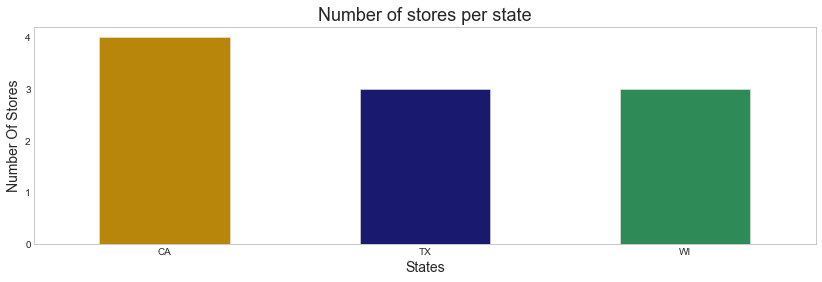

In [59]:
ax = df_sales_train.groupby(['state_id'])['store_id'].describe()['unique'].plot(kind='bar',
                                    figsize=(14,4),
                                    color=['darkgoldenrod','midnightblue','seagreen'])

ax.set_title("Number of stores per state", fontsize= 18)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=360)
ax.set_ylabel("Number Of Stores",fontsize = 14)
ax.set_xlabel("States",fontsize=14)
ax.set_facecolor('white')
ax.grid(False)
plt.show()

### Items per Product Category

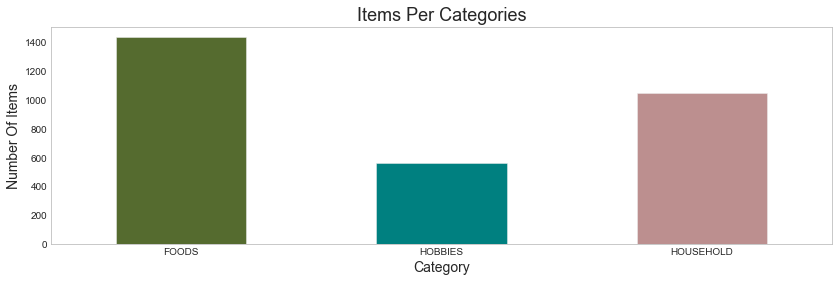

In [61]:
ax = df_sales_train.groupby(['cat_id'])['item_id'].describe()['unique'].plot(kind='bar',
                                    figsize=(14,4),
                                    color=['darkolivegreen','teal','rosybrown'])

ax.set_title("Number of Items Per Categories", fontsize= 18)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=360)
ax.set_ylabel("Number Of Items",fontsize = 14)
ax.set_xlabel("Category",fontsize=14)
ax.set_facecolor('white')
ax.grid(False)
plt.show()

### Items per Department

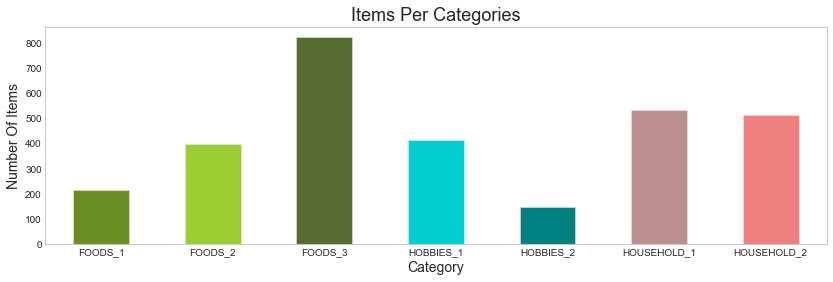

In [62]:
ax = df_sales_train.groupby(['dept_id'])['item_id'].describe()['unique'].plot(kind='bar',
                                    figsize=(14,4),
                                    color=['olivedrab','yellowgreen','darkolivegreen','darkturquoise','teal','rosybrown','lightcoral'])

ax.set_title("Number of Items Per Categories", fontsize= 18)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=360)
ax.set_ylabel("Number Of Items",fontsize = 14)
ax.set_xlabel("Category",fontsize=14)
ax.set_facecolor('white')
ax.grid(False)
plt.show()

## Data manipulation for Time Series analysis

In [63]:
#Create date index
date_index = df_calendar['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

In [65]:
# Create a data frame for items sales per day with item ids (with Store Id) as columns names  and dates as the index 
df_sales_train['item_store_id'] = df_sales_train.apply(lambda x: x['item_id']+'_'+x['store_id'],axis=1)
DF_Sales = df_sales_train.loc[:,'d_1':'d_1913'].T
DF_Sales.columns = df_sales_train['item_store_id'].values

#Set Dates as index 
DF_Sales = pd.DataFrame(DF_Sales).set_index([dates_list])
DF_Sales.index = pd.to_datetime(DF_Sales.index)

DF_Sales.head()

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,HOBBIES_1_011_CA_1,HOBBIES_1_012_CA_1,HOBBIES_1_013_CA_1,HOBBIES_1_014_CA_1,HOBBIES_1_015_CA_1,HOBBIES_1_016_CA_1,HOBBIES_1_017_CA_1,HOBBIES_1_018_CA_1,HOBBIES_1_019_CA_1,HOBBIES_1_020_CA_1,HOBBIES_1_021_CA_1,HOBBIES_1_022_CA_1,HOBBIES_1_023_CA_1,HOBBIES_1_024_CA_1,HOBBIES_1_025_CA_1,...,FOODS_3_803_WI_3,FOODS_3_804_WI_3,FOODS_3_805_WI_3,FOODS_3_806_WI_3,FOODS_3_807_WI_3,FOODS_3_808_WI_3,FOODS_3_809_WI_3,FOODS_3_810_WI_3,FOODS_3_811_WI_3,FOODS_3_812_WI_3,FOODS_3_813_WI_3,FOODS_3_814_WI_3,FOODS_3_815_WI_3,FOODS_3_816_WI_3,FOODS_3_817_WI_3,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
2011-01-29,0,0,0,0,0,0,0,12,2,0,0,0,0,0,4,5,0,0,0,0,0,2,2,0,0,...,0,14,0,0,7,4,0,0,0,0,0,0,0,0,0,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,0,2,0,0,0,1,0,0,0,0,0,1,1,0,0,...,0,7,0,0,6,13,0,0,0,4,0,0,0,0,1,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,...,0,6,0,0,9,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,0,...,0,9,0,0,1,1,0,0,0,1,0,0,0,0,1,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,2,0,0,...,0,0,0,0,6,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,0,0,2,0,0


## Time series visualization - Selecting a item randomly

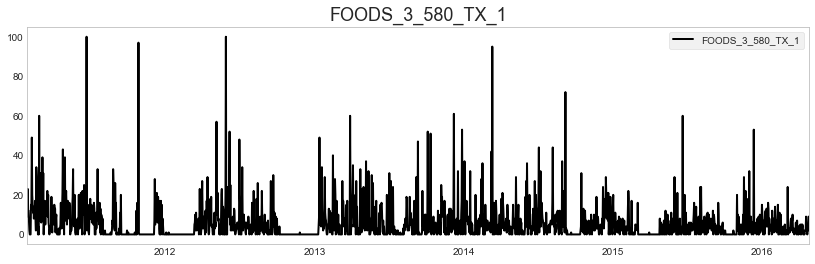

In [84]:
index = 15000
#y = df_sales_train.loc[index,'d_1':'d_1913'].T
y = pd.DataFrame(DF_Sales.iloc[:,index])
y = pd.DataFrame(y).set_index([dates_list])
y.index = pd.to_datetime(y.index)

ax = y.plot(figsize=(14, 4),color='black')
ax.set_title(y.columns.values[0], fontsize= 18)
ax.set_facecolor('white')
ax.grid(False)
plt.show()

## Time series visualization - Visualizing items across departments

In [85]:
# Make a dropdown to select the Department
Department = widgets.Dropdown(
    options= list(df_sales_train['dept_id'].unique()),
    value='FOODS_1',
    style = {'description_width': 'initial'},
    description='Select Department:',    
)


#Plot some examples from the selected category 
def Plot_Rand_TS_From_Department(Department,Seed = 43):
    col_index = DF_Sales.columns[DF_Sales.columns.str.contains(pat = Department)]
    random.seed(Seed)
    examples_index = random.sample(list(col_index),24)
    ts_sample = DF_Sales[examples_index]




    fig, axs = plt.subplots(8, 3, figsize=(18, 22))
    axs = axs.flatten()
    ax_idx = 0
    for item in ts_sample.columns:
        ax = ts_sample[item].plot(title=item,
                                  fontsize = 14,
                                  color=next(color_cycle),
                                  ax=axs[ax_idx])
        ax.set_xlabel("Date",size=15)
        ax.set_ylabel("Item Sold",size = 15)
        ax_idx += 1
    plt.tight_layout()
    plt.show()


out = interactive(Plot_Rand_TS_From_Department,Department = Department,Seed = 43)
out 


interactive(children=(Dropdown(description='Select Department:', index=4, options=('HOBBIES_1', 'HOBBIES_2', '…

## Time series visualization - Visualizing trend of the same item in different stores

In [87]:
#Plot some examples from specific category across all stores 



# Make a dropdown to select the Department
Department = widgets.Dropdown(
    options= list(df_sales_train['dept_id'].unique()),
    value='FOODS_1',
    style = {'description_width': 'initial'},
    description='Select Department:', 
 
)

# Make a dropdown to select the item
item = widgets.BoundedFloatText(
    #department = Department.observe(on_value_change, names='value'),
    #minmax = Calc_Min_Max_Item(department = Department.observe(on_value_change, names='value')),
    value=55,
    min=0,
    max=1000,
    style = {'description_width': 'initial'},
    step=1,
    description='Item Numberr:',
    disabled=False,
    color='black'
)


def Plot_TS_Items_Across_Stores(Department,Item) : 
    Item = int(Item)
    if Item < 10:
        ItemS = '00'+str(Item)
    if Item >9 and Item < 100:
         ItemS = '0'+str(Item)
    if Item > 99 :
        ItemS = str(Item)
    if Item == None:
        ItemS = '001'
    select_item =str(Department)+'_'+str(ItemS)
     
    examples_index = DF_Sales.columns[DF_Sales.columns.str.contains(pat = select_item)]
    
    if len(examples_index) ==0 : 
        select_item =str(Department)+'_'+str('001')
        examples_index = DF_Sales.columns[DF_Sales.columns.str.contains(pat = select_item)]
            
    ts_sample = DF_Sales[examples_index]


    fig, axs = plt.subplots(5, 2, figsize=(15, 10))
    axs = axs.flatten()
    ax_idx = 0
    for item in ts_sample.columns:
        ax = ts_sample[item].plot(title=item,
                                  fontsize = 14,
                                  color=next(color_cycle),
                                  ax=axs[ax_idx])
        ax_idx += 1
        ax.set_xlabel("Date",size=15)
        ax.set_ylabel("Item Sold",size = 15)
    plt.tight_layout()
    plt.show()
    

interactive(Plot_TS_Items_Across_Stores,Department = Department,Item = item)

interactive(children=(Dropdown(description='Select Department:', index=4, options=('HOBBIES_1', 'HOBBIES_2', '…

## Time Series Visualisation

## Aggregation : Unit sales of all products aggregated for each state

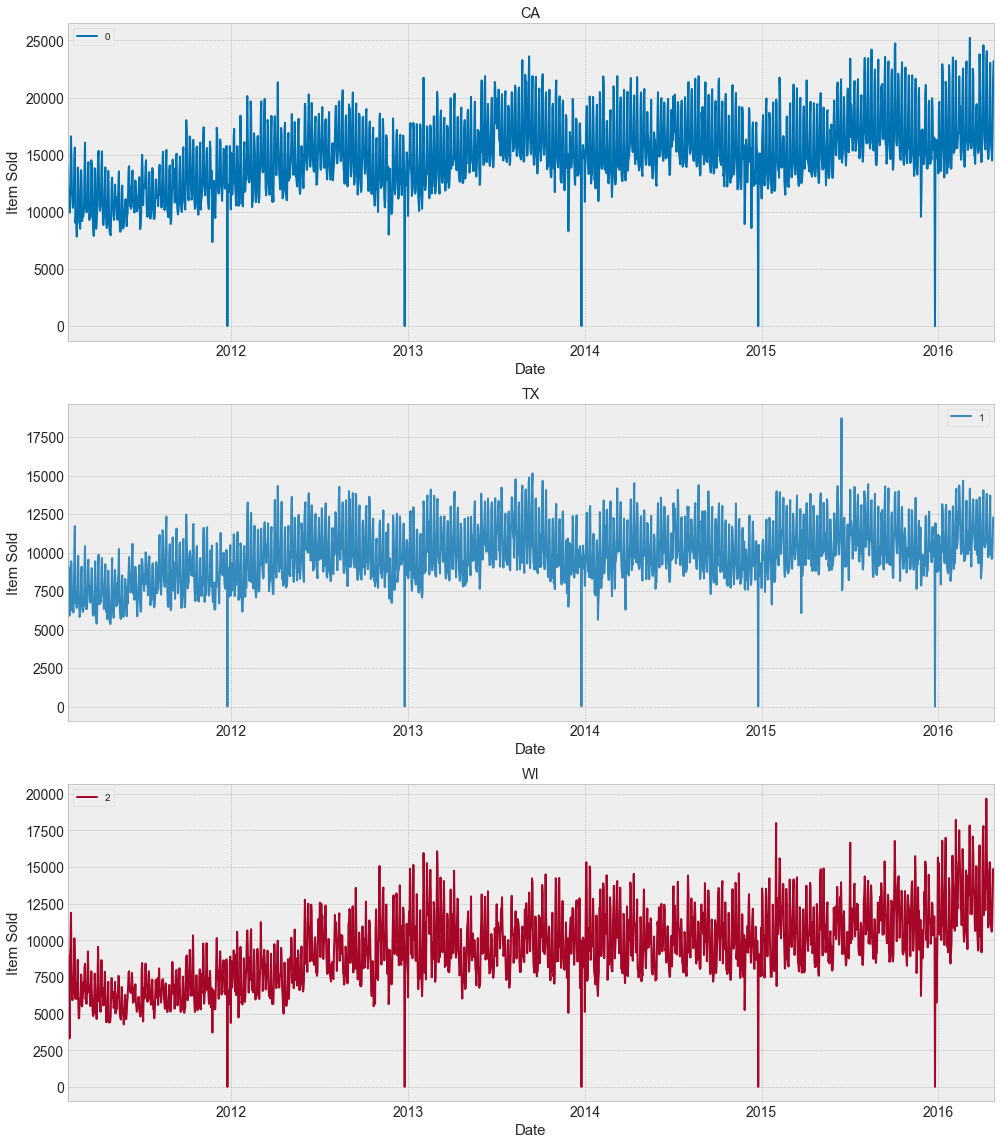

In [97]:
date_index = df_calendar['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]
df = df_sales_train.groupby(['state_id'])[df_sales_train.filter(regex='d_.*').columns].sum()
df = df.reset_index()


fig, axs = plt.subplots(3,1, figsize=(14, 16))
axs = axs.flatten()

ax_idx = 0

for index, row in df.iterrows():
    y = pd.DataFrame(row['d_1':'d_1913']).set_index([dates_list])
    y.index = pd.to_datetime(y.index)
     
    
    ax = y.plot(title=row.state_id,
                                          fontsize = 14,
                                          color=next(color_cycle),
                                        ax=axs[ax_idx])
     
    ax_idx += 1
    ax.set_xlabel("Date",size=15)
    ax.set_ylabel("Item Sold",size = 15)
     
     
plt.tight_layout()
plt.show()

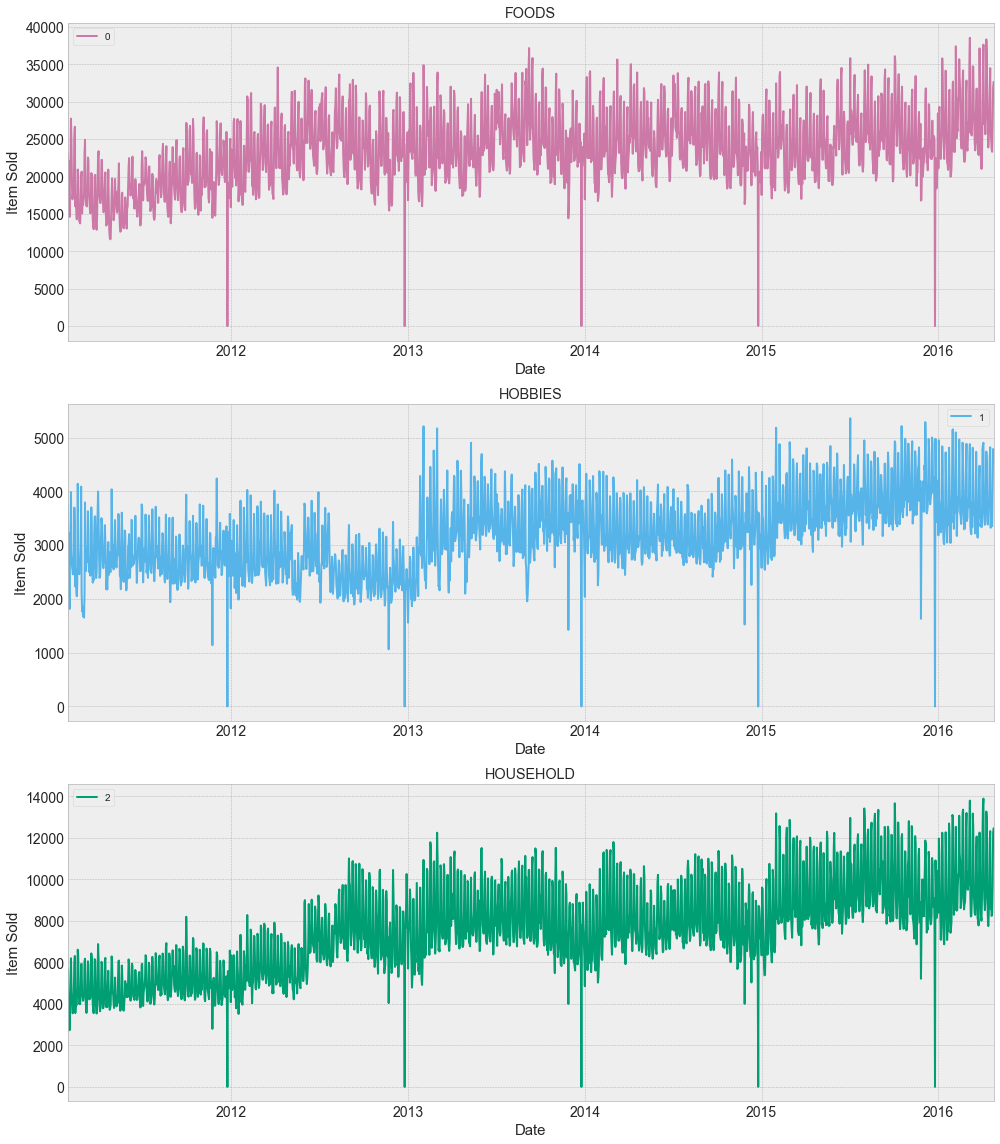

In [113]:
date_index = df_calendar['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]
df = df_sales_train.groupby(['cat_id'])[df_sales_train.filter(regex='d_.*').columns].sum()
df = df.reset_index()


fig, axs = plt.subplots(3,1, figsize=(14, 16))
axs = axs.flatten()

ax_idx = 0

for index, row in df.iterrows():
    y = pd.DataFrame(row['d_1':'d_1913']).set_index([dates_list])
    y.index = pd.to_datetime(y.index)
     
    
    ax = y.plot(title=row.cat_id,
                                          fontsize = 14,
                                          color=next(color_cycle),
                                        ax=axs[ax_idx])
     
    ax_idx += 1
    ax.set_xlabel("Date",size=15)
    ax.set_ylabel("Item Sold",size = 15)
     
     
plt.tight_layout()
plt.show()

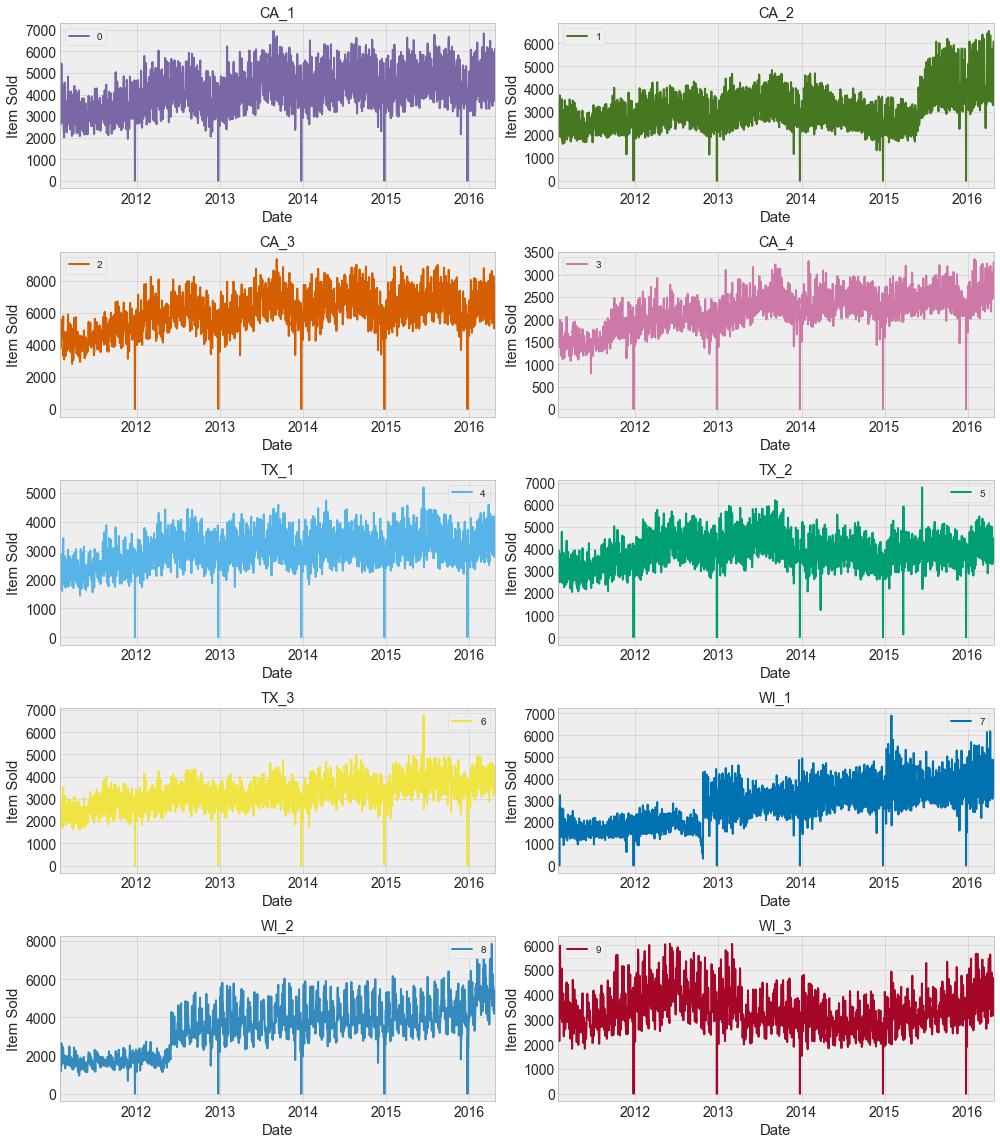

In [115]:
date_index = df_calendar['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]
df = df_sales_train.groupby(['store_id'])[df_sales_train.filter(regex='d_.*').columns].sum()
df = df.reset_index()


fig, axs = plt.subplots(5,2, figsize=(14, 16))
axs = axs.flatten()

ax_idx = 0

for index, row in df.iterrows():
    y = pd.DataFrame(row['d_1':'d_1913']).set_index([dates_list])
    y.index = pd.to_datetime(y.index)
     
    
    ax = y.plot(title=row.store_id,
                                          fontsize = 14,
                                          color=next(color_cycle),
                                        ax=axs[ax_idx])
     
    ax_idx += 1
    ax.set_xlabel("Date",size=15)
    ax.set_ylabel("Item Sold",size = 15)
     
     
plt.tight_layout()
plt.show()

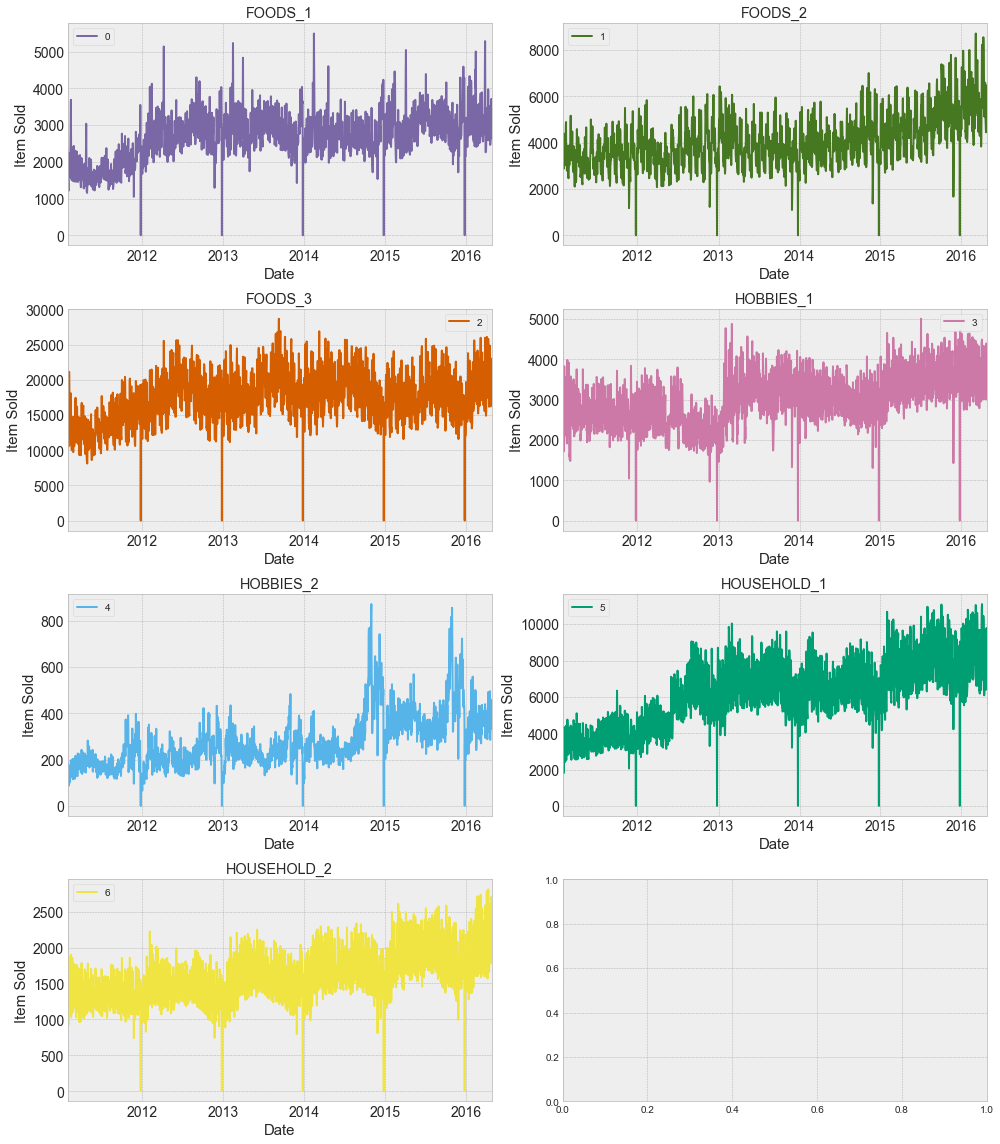

In [116]:
date_index = df_calendar['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]
df = df_sales_train.groupby(['dept_id'])[df_sales_train.filter(regex='d_.*').columns].sum()
df = df.reset_index()


fig, axs = plt.subplots(4,2, figsize=(14, 16))
axs = axs.flatten()

ax_idx = 0

for index, row in df.iterrows():
    y = pd.DataFrame(row['d_1':'d_1913']).set_index([dates_list])
    y.index = pd.to_datetime(y.index)
     
    
    ax = y.plot(title=row.dept_id,
                                          fontsize = 14,
                                          color=next(color_cycle),
                                        ax=axs[ax_idx])
     
    ax_idx += 1
    ax.set_xlabel("Date",size=15)
    ax.set_ylabel("Item Sold",size = 15)
     
     
plt.tight_layout()
plt.show()